# SemEval Task 8
##Subtask A- Monolingual Track
Group Number: 6

Members:
- Sagar Swami Rao Kulkarni
- Upvandeep Kaur
- Shrestha Acharya


In [ ]:
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import evaluate
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
torch.manual_seed(100)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(100)

In [ ]:
device = torch.device("cuda")

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/NLPSharedTask/SemEval2024-task8/subtaskA')

Mounted at /content/drive


In [ ]:
train_path =  '/content/drive/MyDrive/NLPSharedTask/SubtaskA/subtaskA_train_monolingual.jsonl'
test_path =  '/content/drive/MyDrive/NLPSharedTask/SubtaskA/subtaskA_dev_monolingual.jsonl'

train_df = pd.read_json(train_path, lines=True)
test_data = pd.read_json(test_path, lines=True)

train_data, val_data = train_test_split(train_df, test_size=0.1, random_state=42)

In [ ]:
print('Train:', train_data.shape)
print('Validation:', val_data.shape)

Train: (107781, 5)
Validation: (11976, 5)


In [ ]:
train_data.columns

Index(['text', 'label', 'model', 'source', 'id'], dtype='object')

In [ ]:
train_data.head()

,text,label,model,source,id
18106,"As a 10-year-old, I can tell you that I rely o...",1,davinci,reddit,18106
35202,\n\nIf you want to set up a modern Blu-ray pla...,1,davinci,wikihow,35202
70947,"Reset circuit breaker to ""On"" or replace any ...",0,human,wikihow,70947
90188,Think of it this way - there are three main ro...,0,human,reddit,90188
60087,First off every shooter has a different routi...,0,human,wikihow,60087


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe['text'].values.tolist()
        self.labels = dataframe['label'].values.tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        X = self.texts[idx]
        y = self.labels[idx]
        X = X.lower()
        tokens = nltk.word_tokenize(X, language="english")
        X = " ".join(tokens)
        X = X.strip()

        return X, y

In [ ]:
class transformer(nn.Module):
    def __init__(self, base_model):
        super(transformer, self).__init__()

        self.bert = base_model
        self.fc = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids,
                             attention_mask=attention_mask)[0][:, 0]
        x = self.fc(bert_out)
        x = self.sigmoid(x)

        return x

In [ ]:
def collate_fn(batch):
    x, y = [], []
    for text, label in batch:
        x.append(text)
        y.append(label)
    padded_text = tokenizer(x, padding=True, truncation=True, return_tensors='pt')

    return padded_text, torch.FloatTensor(y)

In [ ]:
BERT_MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
os.makedirs('model1107',exist_ok=True)
os.chdir('/content/drive/MyDrive/NLPSharedTask/SemEval2024-task8/subtaskA/model1107')

In [ ]:
ls

roberta-base-1.pt


## TRAINING

In [ ]:
# IF USING PRETRAINED MODEL
base_model = AutoModel.from_pretrained(BERT_MODEL)
model = transformer(base_model)
model = torch.nn.DataParallel(model)
model = model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# # IF LOADING A MODEL AND CONTINUING TRAINING
# pretrained_model_path='roberta-base-1.pt'
# model= torch.load(pretrained_model_path)
# model = model.to(device)

In [ ]:
def collate_fn(batch):
    x, y = [], []
    for text, label in batch:
        x.append(text)
        y.append(label)
    padded_text = tokenizer(x, padding=True, truncation=True, return_tensors='pt')

    return padded_text, torch.FloatTensor(y)

In [ ]:
train_dataloader = DataLoader(Dataset(train_data), batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True, worker_init_fn=seed_worker, generator=g)
val_dataloader = DataLoader(Dataset(val_data), batch_size=16, num_workers=4, collate_fn=collate_fn, pin_memory=True, worker_init_fn=seed_worker, generator=g)

In [ ]:
for train_input, train_label in train_dataloader:
    print(np.array(train_input['input_ids']).shape)
    break

(16, 512)


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
count_train = 0
count_test = 0
best_val_loss = float('inf')
early_stopping_threshold_count = 0

for epoch in range(5):
    total_loss_train = 0
    total_f1_train = 0

    model.train()

    for train_input, train_label in tqdm(train_dataloader):
        train_label = train_label.to(device)
        attention_mask = train_input['attention_mask'].to(device)
        input_ids = train_input['input_ids'].squeeze(1).to(device)
        output = model(input_ids, attention_mask)
        loss = criterion(output, train_label.float().unsqueeze(1))
        total_loss_train += loss.item()
        pred = (output >= 0.5).int()
        label = train_label.unsqueeze(1)
        f1_train = f1_score(label.cpu(), pred.cpu())
        total_f1_train += f1_train

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        total_loss_val = 0
        total_f1_val = 0

        model.eval()

        for val_input, val_label in val_dataloader:
            val_label = val_label.to(device)
            attention_mask = val_input['attention_mask'].to(device)
            input_ids = val_input['input_ids'].squeeze(1).to(device)
            output = model(input_ids, attention_mask)
            loss = criterion(output, val_label.float().unsqueeze(1))
            total_loss_val += loss.item()
            pred = (output >= 0.5).int()
            label = val_label.unsqueeze(1)
            f1_val = f1_score(label.cpu(), pred.cpu())
            total_f1_val += f1_val

        print("Epochs:", epoch + 1)
        print("Train Loss:", total_loss_train/len(train_dataloader))
        print("Train F1 Score:", total_f1_train/len(train_dataloader))

        print("Val Loss:", total_loss_val/len(val_dataloader))
        print("Val F1 Score:", total_f1_val/len(val_dataloader))

        if best_val_loss > total_loss_val:
            best_val_loss = total_loss_val
            torch.save(model, f"roberta-base-"+str(epoch)+".pt")
            print("Model Saved")
            early_stopping_threshold_count = 0
        else:
            early_stopping_threshold_count += 1

        if early_stopping_threshold_count >= 1:
            print("Early Stopping")
            break

        count_train = 0
        count_test = 0

        print("====================================================================================")


100%|██████████| 6737/6737 [50:54<00:00,  2.21s/it]


Epochs: 1
Train Loss: 0.09446299709224003
Train F1 Score: 0.9579865183158341
Val Loss: 0.07459868401291834
Val F1 Score: 0.9631586245613245
Model Saved


100%|██████████| 6737/6737 [50:50<00:00,  2.21s/it]


Epochs: 2
Train Loss: 0.047417137917399654
Train F1 Score: 0.9806359502865684
Val Loss: 0.09829576973315221
Val F1 Score: 0.958451572475


100%|██████████| 6737/6737 [50:51<00:00,  2.21s/it]


Epochs: 3
Train Loss: 0.02901661536484561
Train F1 Score: 0.9882138809218369
Val Loss: 0.231960912389722
Val F1 Score: 0.92215332980730303
Early Stopping


In [ ]:
from google.colab import runtime
runtime.unassign()

### TEST

In [ ]:
os.listdir('/content/drive/MyDrive/NLPSharedTask/SemEval2024-task8/subtaskA/model1107/')

['roberta-base-1.pt']

In [ ]:
os.chdir('/content/drive/MyDrive/NLPSharedTask/SemEval2024-task8/subtaskA/model1107/')

In [ ]:
model = torch.load('roberta-base-1.pt')
model = model.to(device)
model.eval()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
from sklearn.metrics import f1_score
model = torch.load('roberta-base-1.pt')
model = model.to(device)
model.eval()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

test_dataloader = DataLoader(Dataset(test_data), batch_size=1, num_workers=8, collate_fn=collate_fn, pin_memory=True, worker_init_fn=seed_worker, generator=g)
total_acc_test = 0
total_loss_test = 0
total_f1_test = 0
count_test = 0
pred_array=[]
act_array=[]
for test_input, test_label in test_dataloader:
    attention_mask = test_input['attention_mask'].to(device)
    input_ids = test_input['input_ids'].squeeze(1).to(device)

    test_label = test_label.to(device)

    output = model(input_ids, attention_mask)

    loss = criterion(output, test_label.float().unsqueeze(1))

    total_loss_test += loss.item()

    pred = (output >= 0.5).int()
    label = test_label.unsqueeze(1)
    pred_array.append(pred.cpu().item())
    act_array.append(label.cpu().item())
    f1_test = f1_score(label.cpu(), pred.cpu(), average='binary', zero_division=1)
    total_f1_test += f1_test

print("Test F1 Score:", total_f1_test/(len(test_dataloader)))

Test F1 Score: 0.844


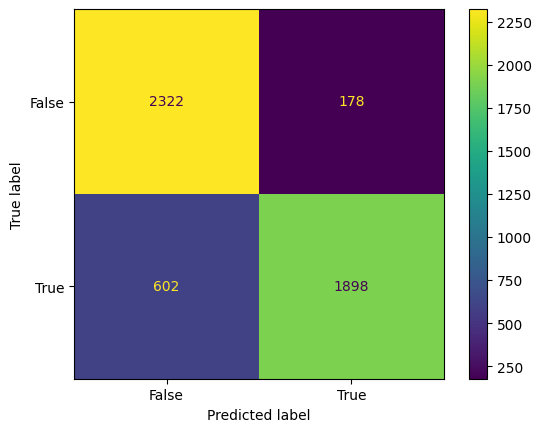

In [ ]:
confusion_matrix = metrics.confusion_matrix(act_array, pred_array)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
metric = evaluate.load("bstrai/classification_report")
results = metric.compute(predictions=pred_array, references=act_array)

In [ ]:
results

{'0': {'precision': 0.7941176470588235,
  'recall': 0.9288,
  'f1-score': 0.8561946902654867,
  'support': 2500},
 '1': {'precision': 0.9142581888246628,
  'recall': 0.7592,
  'f1-score': 0.8295454545454547,
  'support': 2500},
 'accuracy': 0.844,
 'macro avg': {'precision': 0.8541879179417431,
  'recall': 0.844,
  'f1-score': 0.8428700724054707,
  'support': 5000},
 'weighted avg': {'precision': 0.8541879179417432,
  'recall': 0.844,
  'f1-score': 0.8428700724054706,
  'support': 5000}}

In [ ]:
prediction_path ='subtaskA_predictions.jsonl'
logging.info(results)
predictions_df = pd.DataFrame({'id': test_data['id'], 'label': pred_array})

In [ ]:
predictions_df

,id,label
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
4995,4995,0
4996,4996,0
4997,4997,0
4998,4998,0


In [ ]:
predictions_df.to_json(prediction_path, lines=True, orient='records')